In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ====================================================
# 1. Load CSV files into DataFrames
# ====================================================
df_assessments       = pd.read_csv("assessments.csv")
df_courses           = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo       = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle        = pd.read_csv("studentVle.csv")
df_vle               = pd.read_csv("vle.csv")

# ====================================================
# 2. Create a Unique Module Identifier
# ====================================================
# Merge code_module and code_presentation into a new column: module_presentation
df_courses["module_presentation"]           = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_courses.code_module, df_courses.code_presentation))
df_assessments["module_presentation"]       = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_assessments.code_module, df_assessments.code_presentation))
df_vle["module_presentation"]               = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_vle.code_module, df_vle.code_presentation))
df_studentInfo["module_presentation"]       = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentInfo.code_module, df_studentInfo.code_presentation))
df_studentRegistration["module_presentation"] = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentRegistration.code_module, df_studentRegistration.code_presentation))
df_studentVle["module_presentation"]        = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentVle.code_module, df_studentVle.code_presentation))

print("In Student Info table; \n# of rows: {} \n# of unique student Ids: {} \n"
      "Hence, there are different records for the same student's different module enrolments."
      .format(len(df_studentInfo), len(df_studentInfo.id_student.unique())))
print("\nThis also means that student ID is not really a unique identifier of the table.\n")

# ====================================================
# 3. Consistency Check: Registration vs. Final Result
# ====================================================
# Identify students with a non-null unregistration date (i.e. unregistered students)
temp = df_studentRegistration.loc[
    df_studentRegistration.date_unregistration.notna(),
    ['id_student', 'module_presentation', 'date_unregistration']
]

# Merge the registration info with student info on id_student and module_presentation
temp_merge = pd.merge(df_studentInfo, temp,
                      on=['id_student', 'module_presentation'],
                      how='left')

# Check for inconsistencies: if a student unregistered, final_result must be "Withdrawn"
inconsistencies = temp_merge.loc[
    temp_merge.date_unregistration.notna() & (temp_merge.final_result != 'Withdrawn')
]
print("Inconsistencies between registration and final_result (if any):")
print(inconsistencies)

# ====================================================
# 4. Feature Aggregation
# ====================================================
# 4.1 Count the total number of assessments per module (grouped by code_module and code_presentation)
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# 4.2 Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# 4.3 Compute the average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "score"})
)

# 4.4 Sum total VLE clicks for each student
df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# ====================================================
# 5. Merge DataFrames to Create the Analysis Dataset
# ====================================================
# Merge total assessments into studentInfo based on code_module and code_presentation
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# Merge attempted assessments count (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

# Merge average score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# Merge total VLE clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Fill missing values with 0 for count/sum fields
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"]           = df_merged["total_assessments"].fillna(0)
df_merged["score"]                       = df_merged["score"].fillna(0)
df_merged["total_vle_clicks"]            = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment completion ratio safely (avoiding division by zero)
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# ====================================================
# 6. Create Binary Target: Withdrawn vs. Not Withdrawn
# ====================================================
# Instead of filtering out withdrawn students, we keep all records and define:
#   target = 1 if final_result is "Withdrawn", else 0.
df_merged["target"] = df_merged["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# ====================================================
# 7. Final DataFrame for Modeling
# ====================================================
# Optionally, rename columns for clarity (example renaming)
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# Select relevant features along with the new target variable
df_final = df_merged[
    [
        "id_student",
        "code_module",            # module feature
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


In Student Info table; 
# of rows: 32593 
# of unique student Ids: 28785 
Hence, there are different records for the same student's different module enrolments.

This also means that student ID is not really a unique identifier of the table.

Inconsistencies between registration and final_result (if any):
      code_module code_presentation  id_student gender                region  \
2777          BBB             2013J      362907      F     South West Region   
2786          BBB             2013J      365288      F          South Region   
3340          BBB             2013J      554243      F     South West Region   
14625         DDD             2013J      315082      M  West Midlands Region   
14768         DDD             2013J      403052      F      Yorkshire Region   
15577         DDD             2013J      582954      M         London Region   
24057         FFF             2013J      234004      M      Yorkshire Region   
24537         FFF             2013J      523777      

  code_module  score Gender                Region                    HLE  \
0         AAA   82.0      M   East Anglian Region       HE Qualification   
1         AAA   66.4      F              Scotland       HE Qualification   
2         AAA    0.0      F  North Western Region  A Level or Equivalent   
3         AAA   76.0      F     South East Region  A Level or Equivalent   
4         AAA   54.4      F  West Midlands Region     Lower Than A Level   

  Age group  Credit Distribution  assessment_completion_ratio  \
0      55<=                  240                     0.833333   
1     35-55                   60                     0.833333   
2     35-55                   60                     0.000000   
3     35-55                   60                     0.833333   
4      0-35                   60                     0.833333   

   total_vle_clicks  target      PCA1      PCA2  DBSCAN_Cluster  
0             934.0       0  0.465715 -0.685656               0  
1            1435.0 

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

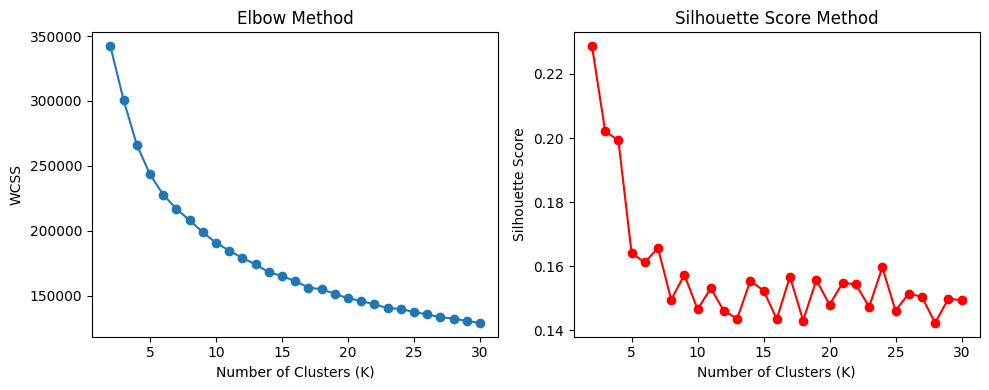

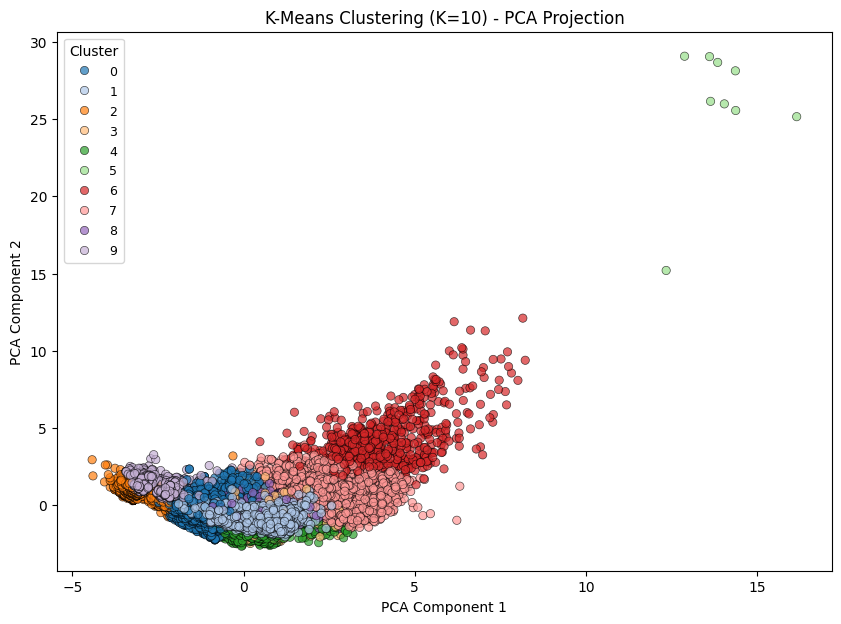

Cluster Means:
         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           2.952229  69.379728  0.617152  5.956551  1.062557   0.252502   
1           5.842105  77.123971  0.130031  5.677576  1.345865   0.392747   
2           1.741565   2.161587  0.045585  5.809763  1.186289   0.273510   
3           1.993781  74.623604  0.461373  5.830902  1.052380   1.036116   
4           1.607497  72.711568  0.000646  6.095864  0.868160   0.000000   
5           3.333333  90.362613  0.666667  6.222222  0.888889   0.000000   
6           3.591703  82.229400  0.681223  5.536026  1.138646   0.658297   
7           4.087091  78.287970  0.819649  5.737542  0.902943   0.279782   
8           3.518238  72.063852  1.000000  5.941676  0.843445   0.005237   
9           3.966849   1.759803  0.873151  5.905753  1.195342   0.263562   

         Credit Distribution  assessment_completion_ratio  total_vle_cli

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===========================
# Data Preprocessing
# ===========================

# Load your processed dataframe
df = df_final.copy()

# Drop student ID (not relevant for clustering)
df = df.drop(columns=['id_student'])

# Print the first few rows to check features
print(df.head())

# Encode categorical variables (using all features except numeric ones)
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Standardize all features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# ===========================
# Finding Optimal K (Elbow & Silhouette Methods)
# ===========================

wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 30 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

# Plot the Elbow Method results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

plt.tight_layout()
plt.show()

# ===========================
# Applying K-Means with Optimal K
# ===========================
optimal_k = 10  # Choose optimal K based on the above plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# ===========================
# Visualizing Clusters using PCA
# ===========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', 
    data=df, palette="tab20", alpha=0.7, edgecolor="black"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k}) - PCA Projection")

# Adjust legend font size for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)

plt.show()

# ===========================
# Display Cluster Statistics
# ===========================
print("Cluster Means:")
print(df.groupby('Cluster').mean())
